In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from climtas.nci import GadiClient
from sea_breeze.sea_breeze_funcs import kinematic_frontogenesis, kinematic_frontogenesis_metpy, coast_relative_frontogenesis, load_angle_ds, single_col_circulation, moisture_flux_gradient
import metpy.calc as mpcalc
import metpy.units as units
import datetime as dt
import tqdm
from sea_breeze.load_model_data import load_aus2200_static, load_aus2200_variable, destagger_aus2200, round_times, interp_times
import numpy as np
from sea_breeze.load_obs import load_half_hourly_stn_obs

In [2]:
GadiClient()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 18.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36925,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 18.00 GiB
Comm: tcp://127.0.0.1:42691,Total threads: 1
Dashboard: /proxy/43581/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:38289,


In [3]:
lat_slice=slice(-38,-30)
lon_slice=slice(112,120)
t1="2016-01-21 00:00"
t2="2016-01-28 00:00"

In [5]:
#Load AUS2200 sfc level data, and static fields (lsm, coastline angles)

destag_time_chunk = 50
destag_latlon_chunk = -1
dt_time_chunk = -1
dt_latlon_chunk = 100
F_time_chunk = 50
F_latlon_chunk = -1

orog, lsm = load_aus2200_static("mjo-elnino",lon_slice,lat_slice)
aus2200_sfc = round_times(load_aus2200_variable(["vas","uas","hus"],t1,t2,"mjo-elnino",lon_slice,lat_slice,"10min",chunks="auto"), "10min")
angle_ds = load_angle_ds("/g/data/gb02/ab4502/coastline_data/aus2200_v3.nc",lat_slice,lon_slice)

#Rechunk for interpolation/destaggering in space
aus2200_sfc["uas"] = aus2200_sfc["uas"].chunk({"time":destag_time_chunk,"lat":destag_latlon_chunk,"lon":destag_latlon_chunk})
aus2200_sfc["vas"] = aus2200_sfc["vas"].chunk({"time":destag_time_chunk,"lat":destag_latlon_chunk,"lon":destag_latlon_chunk})
aus2200_sfc["hus"] = aus2200_sfc["hus"].chunk({"time":destag_time_chunk,"lat":destag_latlon_chunk,"lon":destag_latlon_chunk})

In [6]:
#Destagger the u and v winds, and put into a single xarray Dataset
aus2200_sfc = destagger_aus2200_xesmf(aus2200_sfc,["uas","vas"],interp_to="hus",lsm=None)
aus2200_sfc_wind = xr.Dataset({"u":aus2200_sfc["uas"], "v":aus2200_sfc["vas"]})

--------------------------------------------------------------------------
but there are no active ports detected (or Open MPI was unable to use
them).  This is most certainly not what you wanted.  Check your
cables, subnet manager configuration, etc.  The openib BTL will be
ignored for this job.

  Local host: gadi-cpu-bdw-0005
--------------------------------------------------------------------------


In [7]:
#Rechunk everything back so we only have one time chunk, as we are now calculating the time rate of change
aus2200_sfc["hus"] = aus2200_sfc["hus"].chunk({"time":dt_time_chunk,"lat":dt_latlon_chunk,"lon":dt_latlon_chunk})
aus2200_sfc_wind = aus2200_sfc_wind.chunk({"time":dt_time_chunk,"lat":dt_latlon_chunk,"lon":dt_latlon_chunk})

In [8]:
#Calculate rate of change in moisture flux
F_dqu = moisture_flux_gradient(
    aus2200_sfc["hus"],
    aus2200_sfc_wind["u"],
    aus2200_sfc_wind["v"],
    angle_ds)

In [9]:
#Rechunk everything one latlon chunk, as we are now calculating horizontal gradients
aus2200_sfc["hus"] = aus2200_sfc["hus"].chunk({"time":F_time_chunk,"lat":F_latlon_chunk,"lon":F_latlon_chunk})
aus2200_sfc_wind = aus2200_sfc_wind.chunk({"time":F_time_chunk,"lat":F_latlon_chunk,"lon":F_latlon_chunk})

In [10]:
#Calculate frontogenesis
Fq = kinematic_frontogenesis(
    aus2200_sfc["hus"],
    aus2200_sfc_wind["u"],
    aus2200_sfc_wind["v"])

In [11]:
#Calculate coast-relative frontogensis
Fc = coast_relative_frontogenesis(
    aus2200_sfc["hus"],
    aus2200_sfc_wind["u"],
    aus2200_sfc_wind["v"], angle_ds)

In [12]:
sbi_time_chunks = 50
sbi_latlon_chunks = 100
sbi_lev_chunks = -1

#Load model level wind data for the sea breeze index
aus2200_ml = load_aus2200_variable(["ua","va"],t1,t2,"mjo-elnino",lon_slice,lat_slice,"1hr",hgt_slice=slice(0,5000),chunks="auto")
aus2200_ml = destagger_aus2200(aus2200_ml,["ua","va"],lsm=lsm)
aus2200_wind = xr.Dataset({"u":aus2200_ml["ua"], "v":aus2200_ml["va"]}).chunk({"time":sbi_time_chunks,"lev":sbi_lev_chunks,"lat":sbi_latlon_chunks,"lon":sbi_latlon_chunks})

#Load boundary layer height data for sea breeze index
aus2200_zmla = interp_times(
                            load_aus2200_variable(
                                ["zmla"],t1,t2,"mjo-elnino",lon_slice,lat_slice,"1hr",
                                chunks="auto"),
                            aus2200_wind.time,lower_bound=0)

#Compute SBI with unified chunks
sbi = single_col_circulation(aus2200_wind.rename({"lev":"height"}),
                            angle_ds.chunk({"lat":sbi_latlon_chunks,"lon":sbi_latlon_chunks}),
                            subtract_mean=True,
                            height_mean=False,
                            height_method="blh",
                            blh_da=aus2200_zmla["zmla"].chunk({"time":sbi_time_chunks,"lat":sbi_latlon_chunks,"lon":sbi_latlon_chunks}),
                            alpha_height=0)

In [13]:
#Load observations
obs = load_half_hourly_stn_obs("WA",slice(t1,t2))

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 14.93 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


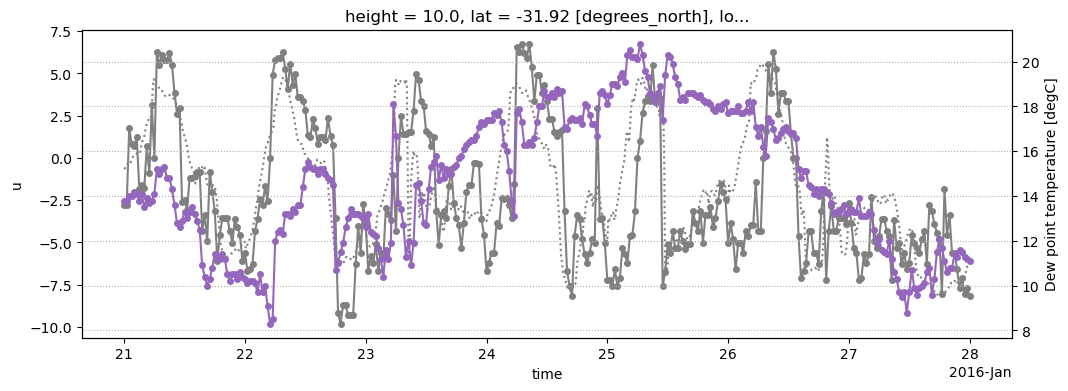

In [14]:
plt.figure(figsize=[12,4])

uax = plt.axes()
obs.sel(station=41).u.plot(ax=uax,marker="o",ms=4,color="grey")
tax = uax.twinx()
obs.sel(station=41).Tdew.plot(ax=tax,color="tab:purple",marker="o",ms=4)
tax.grid(ls=":")


aus2200_sfc_wind["u"]\
    .sel(lat=obs.sel(station=41).lati.values,
        lon=obs.sel(station=41).long.values,method="nearest")\
    .plot(ax=uax,marker="none",ms=4,color="grey",ls=":")


Calculating moisture flux gradient


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 29.95 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Calculating frontogenesis


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 32.42 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Calculating coast-relative frontogenesis


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 37.41 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Calculating SBI


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 31.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


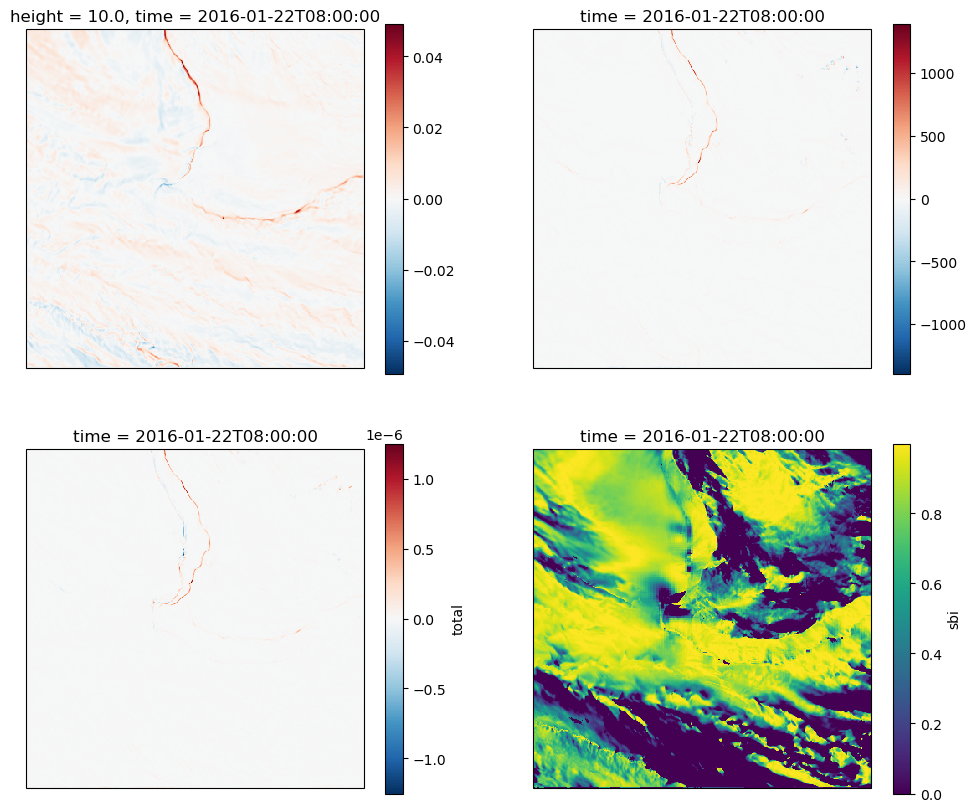

In [15]:
t = "2016-01-22 08:00"

plt.figure(figsize=[12,10])
ax = plt.subplot(2,2,1,projection=ccrs.PlateCarree())
print("Calculating moisture flux gradient")
F_dqu.sel(time=t).plot()

ax = plt.subplot(2,2,2,projection=ccrs.PlateCarree())
print("Calculating frontogenesis")
Fq.sel(time=t).plot()

ax = plt.subplot(2,2,3,projection=ccrs.PlateCarree())
print("Calculating coast-relative frontogenesis")
Fc.total.sel(time=t).plot()

ax = plt.subplot(2,2,4,projection=ccrs.PlateCarree())
print("Calculating SBI")
sbi.sbi.sel(time=t).plot()

In [ ]:
moisture_flux_gradient(
    obs["hus"],obs["u"],obs["v"],angle_ds.sel(
        lat=obs.sel(station=41).lati.values,
        lon=obs.sel(station=41).long.values,method="nearest")
).sel(station=41).plot()

F_dqu.sel(lat=obs.sel(station=41).lati.values,lon=obs.sel(station=41).long.values,method="nearest").plot()

plt.gca().grid(ls=":")
#plt.ylim([-0.1,0.1])

Text(0.5, 1.0, '2d kinematic frontogenesis parameter')

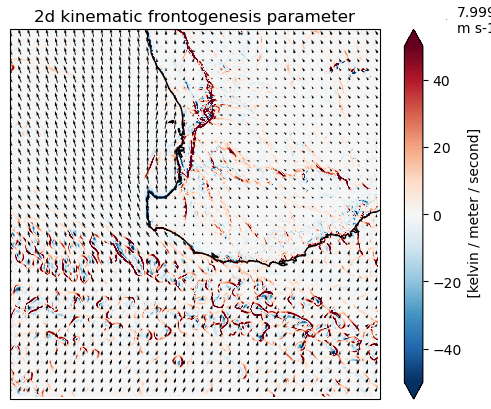

In [13]:
t = "2016-01-21 12:10"

ax = plt.axes(projection=ccrs.PlateCarree())
Fq.sel(time=t).plot(cmap="RdBu_r",vmin=-50,vmax=50)
aus2200_sfc_wind.sel(time=t).squeeze().isel(lat=slice(0,-1,10),lon=slice(0,-1,10)).\
    plot.quiver(x="lon",y="lat",u="u",v="v")
ax.coastlines()

plt.title("2d kinematic frontogenesis parameter")

In [14]:
!rm /g/data/gb02/ab4502/figs/sea_breeze/*.png
cnt=1
for t in tqdm.tqdm([dt.datetime.strptime("2016-01-21 12:00","%Y-%m-%d %H:%M") + dt.timedelta(minutes=i*10) for i in range(0,aus2200_sfc["vas"].time.shape[0]) ]):
    plt.figure(figsize=[14,10])
    ax = plt.axes(projection=ccrs.PlateCarree())

    Fq.sel(time=t,method="nearest").plot(cmap="RdBu_r",vmin=-50,vmax=50,cbar_kwargs={"label": Fq.units.values})
    aus2200_sfc_wind.sel(time=t).squeeze().isel(lat=slice(0,-1,10),lon=slice(0,-1,10)).\
        plot.quiver(x="lon",y="lat",u="u",v="v",scale=500)
    ax.coastlines()
    plt.savefig("/g/data/gb02/ab4502/figs/sea_breeze/"+t.strftime("%Y%m%d%H%M")+".png")
    plt.close()
    cnt=cnt+1

100%|██████████| 145/145 [01:33<00:00,  1.55it/s]


In [15]:
Fc = coast_relative_frontogenesis(aus2200_sfc["hus"]["hus"], aus2200_sfc["uas"]["uas"], aus2200_sfc["vas"]["vas"], angle_ds)

Text(0.5, 1.0, 'Coast-relative moisture frontogenesis')

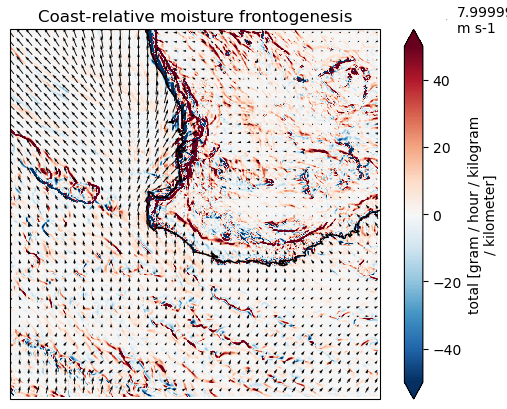

In [16]:
t = "2016-01-22 06:10"

ax = plt.axes(projection=ccrs.PlateCarree())
(Fc["total"]).sel(time=t).plot(cmap="RdBu_r",vmin=-50,vmax=50)
aus2200_sfc_wind.sel(time=t).squeeze().isel(lat=slice(0,-1,10),lon=slice(0,-1,10)).\
    plot.quiver(x="lon",y="lat",u="u",v="v")
ax.coastlines()

plt.title("Coast-relative moisture frontogenesis")

In [17]:
!rm /g/data/gb02/ab4502/figs/sea_breeze/*.png
cnt=1
for t in tqdm.tqdm([dt.datetime.strptime("2016-01-21 12:00","%Y-%m-%d %H:%M") + dt.timedelta(minutes=i*10) for i in range(0,aus2200_sfc["vas"].time.shape[0]) ]):
    plt.figure(figsize=[14,10])
    ax = plt.axes(projection=ccrs.PlateCarree())

    Fc.total.sel(time=t,method="nearest").plot(cmap="RdBu_r",vmin=-50,vmax=50,cbar_kwargs={"label": Fq.units.values})
    aus2200_sfc_wind.sel(time=t).squeeze().isel(lat=slice(0,-1,10),lon=slice(0,-1,10)).\
        plot.quiver(x="lon",y="lat",u="u",v="v",scale=500)
    ax.coastlines()
    plt.savefig("/g/data/gb02/ab4502/figs/sea_breeze/"+t.strftime("%Y%m%d%H%M")+".png")
    plt.close()
    cnt=cnt+1

100%|██████████| 145/145 [01:36<00:00,  1.51it/s]


In [17]:


# F_dudt_dqdt = calc_dudt_dqdt(
#     aus2200_sfc["hus"]["hus"].chunk({"time":-1,"lat":100,"lon":100}).compute(),
#     aus2200_sfc["uas"]["uas"].chunk({"time":-1,"lat":100,"lon":100}).compute(),
#     aus2200_sfc["vas"]["vas"].chunk({"time":-1,"lat":100,"lon":100}).compute(),
#     angle_ds)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 361.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 451.41 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 631.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 631.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Text(0.5, 1.0, 'Rate of change in local moisture flux')

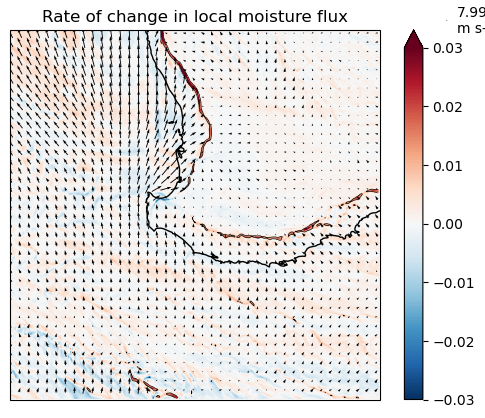

In [19]:
t = "2016-01-22 08:00"
thresh = 0.01

ax = plt.axes(projection=ccrs.PlateCarree())
F_qa.sel(time=t).plot(cmap="RdBu_r",vmin=-.030,vmax=.030)
xr.plot.contour(F_qa.sel(time=t),levels=[thresh],colors="k",linewidths=0.5)
aus2200_sfc_wind.sel(time=t).squeeze().isel(lat=slice(0,-1,10),lon=slice(0,-1,10)).\
    plot.quiver(x="lon",y="lat",u="u",v="v")
ax.coastlines()

plt.title("Rate of change in local moisture flux")

Text(0.5, 1.0, 'Rate of change in local moisture flux')

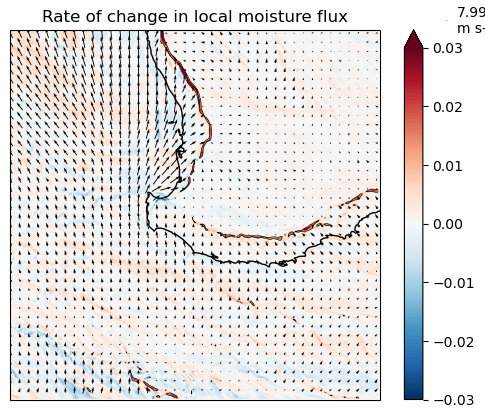

In [18]:
t = "2016-01-22 08:00"
thresh = 0.01

ax = plt.axes(projection=ccrs.PlateCarree())
F_dqu.sel(time=t).plot(cmap="RdBu_r",vmin=-.030,vmax=.030)
xr.plot.contour(F_dqu.sel(time=t),levels=[thresh],colors="k",linewidths=0.5)
aus2200_sfc_wind.sel(time=t).squeeze().isel(lat=slice(0,-1,10),lon=slice(0,-1,10)).\
    plot.quiver(x="lon",y="lat",u="u",v="v")
ax.coastlines()

plt.title("Rate of change in local moisture flux")

In [25]:
!rm /g/data/gb02/ab4502/figs/sea_breeze/*.png
cnt=1
for t in tqdm.tqdm([dt.datetime.strptime("2016-01-21 12:00","%Y-%m-%d %H:%M") + dt.timedelta(minutes=i*10) for i in range(0,aus2200_sfc["vas"].time.shape[0]) ]):
    plt.figure(figsize=[14,10])
    ax = plt.axes(projection=ccrs.PlateCarree())

    F_qa.sel(time=t,method="nearest").plot(cmap="RdBu_r",vmin=-.030,vmax=.030)
    aus2200_sfc_wind.sel(time=t).squeeze().isel(lat=slice(0,-1,10),lon=slice(0,-1,10)).\
        plot.quiver(x="lon",y="lat",u="u",v="v",scale=500)
    ax.coastlines()
    plt.savefig("/g/data/gb02/ab4502/figs/sea_breeze/"+t.strftime("%Y%m%d%H%M")+".png")
    plt.close()
    cnt=cnt+1

rm: cannot remove '/g/data/gb02/ab4502/figs/sea_breeze/*.png': No such file or directory


100%|██████████| 145/145 [01:36<00:00,  1.51it/s]


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 109.90 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Text(0.5, 1.0, 'Sea breeze index')

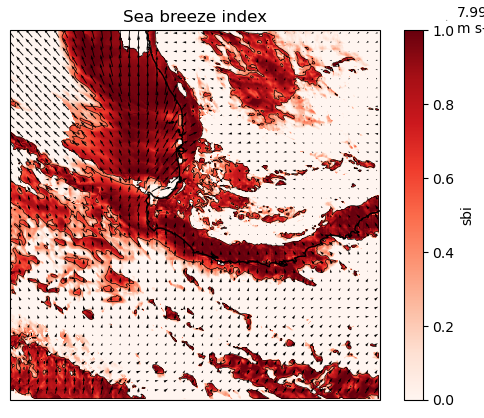

In [14]:
t = "2016-01-22 06:00"
thresh = 0.5

ax = plt.axes(projection=ccrs.PlateCarree())
sbi.sbi.sel(time=t).plot(cmap="Reds",vmin=0,vmax=1)
xr.plot.contour(sbi.sbi.sel(time=t),levels=[thresh],colors="k",linewidths=0.5)
aus2200_sfc_wind.sel(time=t).squeeze().isel(lat=slice(0,-1,10),lon=slice(0,-1,10)).\
    plot.quiver(x="lon",y="lat",u="u",v="v")
ax.coastlines()

plt.title("Sea breeze index")

In [15]:
!rm /g/data/gb02/ab4502/figs/sea_breeze/*.png
cnt=1
for t in tqdm.tqdm([dt.datetime.strptime("2016-01-21 12:00","%Y-%m-%d %H:%M") + dt.timedelta(hours=i) for i in range(0,sbi.time.shape[0]) ]):
    plt.figure(figsize=[14,10])
    ax = plt.axes(projection=ccrs.PlateCarree())

    sbi.sbi.sel(time=t).plot(cmap="Reds",vmin=0,vmax=1)
    aus2200_sfc_wind.sel(time=t).squeeze().isel(lat=slice(0,-1,10),lon=slice(0,-1,10)).\
        plot.quiver(x="lon",y="lat",u="u",v="v",scale=500)
    ax.coastlines()
    plt.savefig("/g/data/gb02/ab4502/figs/sea_breeze/"+t.strftime("%Y%m%d%H%M")+".png")
    plt.close()
    cnt=cnt+1

100%|██████████| 25/25 [00:15<00:00,  1.59it/s]


In [ ]:
v = aus2200_sfc["uas"]["uas"]
q = aus2200_sfc["hus"]["hus"]
v.sel(lat=-33,lon=116,method="nearest").plot(color="tab:red")
plt.gca().twinx()
q.sel(lat=-33,lon=116,method="nearest").plot(color="tab:blue")

In [50]:
import xarray as xr
import metpy
import metpy.calc as mpcalc

def load_half_hourly_stn_obs(state,time_slice):

    '''
    Load half-hourly AWS data and slice based on time. Also convert wind speed and direction to 
    u and v wind components

    state = str, one of "NSW-ACT", "NT", "QLD", "SA", "TAS-ANT", "VIC", "WA"
    time_slice = slice of strings ("%Y-%m-%d %H:%M", "%Y-%m-%d %H:%M")
    '''

    path = "/g/data/w40/clv563/BoM_data_202409/half_hourly_data_netcdf/"
    stn_obs = xr.open_dataset(path + "AWS-data-" + state + ".nc").sel(time=time_slice)
    u,v = metpy.calc.wind_components(
    stn_obs.wspd.metpy.convert_units("m/s"),
    stn_obs.wdir * metpy.units.units.deg)
    stn_obs["u"] = u
    stn_obs["v"] = v

    stn_obs["Tdew"] = stn_obs["Tdew"].assign_attrs(units = "degC")
    stn_obs["hus"] = mpcalc.specific_humidity_from_dewpoint(stn_obs["mslp"],stn_obs["Tdew"])

    return stn_obs

obs = load_half_hourly_stn_obs("WA",slice(t1,t2))

(-0.02, 0.02)

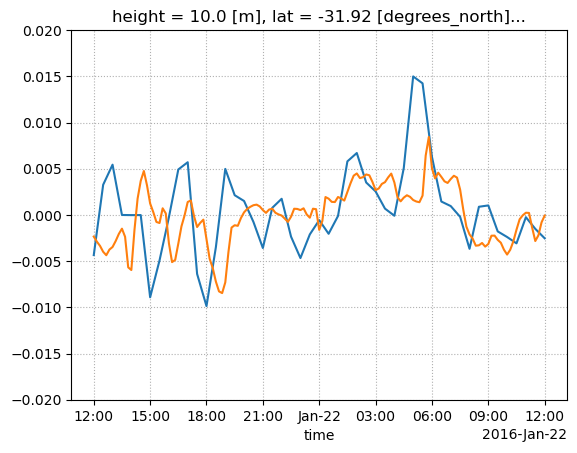

In [65]:
moisture_advection(obs["hus"],obs["u"],obs["v"],angle_ds.sel(lat=obs.sel(station=41).lati.values,
                                                            lon=obs.sel(station=41).long.values,method="nearest") ).sel(station=41).plot()

F_dqu.sel(lat=obs.sel(station=41).lati.values,lon=obs.sel(station=41).long.values,method="nearest").plot()

plt.gca().grid(ls=":")
plt.ylim([-0.02,0.02])